# Hindcast pH Variability

---

**Leading question:** What drives pH variability in the FOSI reconstruction? This will help us to infer what aids in predictability.

Nikki did this in her recent ocean carbon uptake paper, using the following equations (use these first, then find your own fit for them):

```python
pH_T = SSTanom * -0.0155
pH_nonT = pHanom - pH_T
```

These references might help too:

- https://aslopubs.onlinelibrary.wiley.com/doi/full/10.1002/lno.10264
- https://www.ocean-sci.net/14/69/2018/

---

Of course both nonT and T affects were important. So can break the nonT effects down further:

$$ pH_{anom} = \frac{dpH}{dT}\Delta T + \frac{dpH}{dDIC}\Delta DIC + \frac{dpH}{dAlk}\Delta Alk + residual $$

* Temperature Sensitivity: -0.0153/degC
* DIC Sensitivity: -0.0017/mmol/m3 DIC
* ALK Sensitivity: 0.00251/mmol/m3 ALK
* Salt Sensitivity: -0.01342/PSU

---

Salinity normalization:

DIC/SALT * 35

ALK/SALT * 35

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import caldecpred as project
import proplot as plot # Luke Davis' package.
plot.nbsetup()
import esmtools as et
import climpred as cp
from scipy.stats import linregress

import matplotlib.pyplot as plt
%matplotlib inline

### Load in Hindcast Output

The following was all processed, so just loading in now. (had to pre-process with DIC, ALK since these are 3D fields)

```python
pH = project.IO.load_hindcast('PH', dple_time=False, annual=False)

# mask CalCS area
mask = project.IO.load_mask()
pH = pH.where(mask==3)

# time dimension
pH['time'] = pd.date_range('1948-01', '2018-01', freq='M')

# annual means
pH = pH.groupby('time.year').mean('time')

# extract CalCS area
# pH = et.filtering.extract_region(pH, pH.TLONG, pH.TLAT,
#                                           [210, 263, 20, 50])
```

In [2]:
def load_and_process(var, order=1, area_weight=True, detrend=True):
    """
    Will load annual masked CalCS LME for this variable. Then will area-weight and remove
    polynomial fit.
    """
    ds = xr.open_dataset(f'/glade/scratch/rbrady/CalCS_decadal_prediction/masked_LME/{var}.FOSI.CalCS.1948-2017.nc')[var]
    if var in ['SALT', 'ALK', 'DIC']:
        ds = ds.rename({'year': 'initialization'})
    if area_weight:
        ds = et.stats.xr_area_weight(ds, area_coord='TAREA')
    if not area_weight:
        # need to add TLAT/TLONG and extract CalCS region.
        pass
    if detrend:
        ds = cp.stats.xr_rm_poly(ds, order=order, dim='initialization')
    return ds

In [3]:
pH_aw = load_and_process('PH', order=2)
SST_aw = load_and_process('SST')
# salinty-normalizing
SALT_aw = load_and_process('SALT', detrend=False)
ALK_aw = load_and_process('ALK', detrend=False)
DIC_aw = load_and_process('DIC', detrend=False)
sDIC_aw = (DIC_aw/SALT_aw)*35
sALK_aw = (ALK_aw/SALT_aw)*35
# detrend
SALT_aw = cp.stats.xr_rm_poly(SALT_aw, order=1, dim='initialization')
ALK_aw = cp.stats.xr_rm_poly(ALK_aw, order=1, dim='initialization')
DIC_aw = cp.stats.xr_rm_poly(DIC_aw, order=1, dim='initialization')
sDIC_aw = cp.stats.xr_rm_poly(sDIC_aw, order=1, dim='initialization')
sALK_aw = cp.stats.xr_rm_poly(sALK_aw, order=1, dim='initialization')

Summing over nlat
Summing over nlon
Summing over nlat
Summing over nlon
Summing over nlat
Summing over nlon
Summing over nlat
Summing over nlon
Summing over nlat
Summing over nlon


## Look at raw time series

In [4]:
r0 = cp.stats.xr_corr(SST_aw, pH_aw, dim='initialization').values
r1 = cp.stats.xr_corr(SST_aw, pH_aw, dim='initialization', lag=1).values

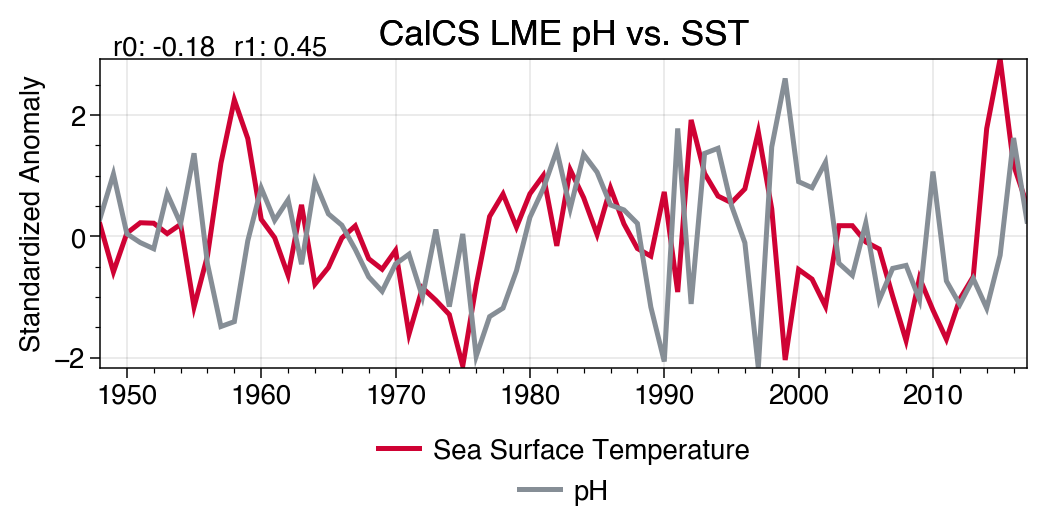

In [5]:
f, ax = plot.subplots(axwidth=5, aspect=3, bottomlegend=True)
plot.rc['figure.facecolor'] = 'w'
plot.rc.small = 11
plot.rc.large = 14

p0 = ax.plot(SST_aw.initialization, (SST_aw/SST_aw.std()), color='cherry',
        label='Sea Surface Temperature', linewidth=2)
p1 = ax.plot(pH_aw.initialization, (pH_aw/pH_aw.std()), color='gray6',
            label='pH', linewidth=2)

ax.format(ylabel='Standardized Anomaly')

ax.text(1949, 3., f'r0: {np.round(r0, 2)}')
ax.text(1958, 3., f'r1: {np.round(r1, 2)}')


plot.rc.large = 14
ax.format(title='CalCS LME pH vs. SST')
f.bottompanel.legend([p0, p1])

#for ext in ['.eps', '.png']:
#    et.vis.savefig('pH.vs.SST.annual', extension=ext, dpi=100)

## Split into pH_T vs. pH_nonT

---

First look is area-weighted to get this process down.

**NOTE**: Sensitivity was calculated in `CO2SYS_pH_temperature_sensitivity` notebook by fixing annual area-weighted mean DIC, Alk, and salinity and then varying temperature.  The resulting fit was -0.0153 per degC.

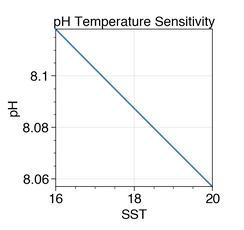

### Annual Means

In [6]:
fac = -0.0153 # derived in CO2SYS_pH_temperature_sensitivity notebook

# Simple decomposition.
pH_T = SST_aw * fac
pH_nonT = pH_aw - pH_T

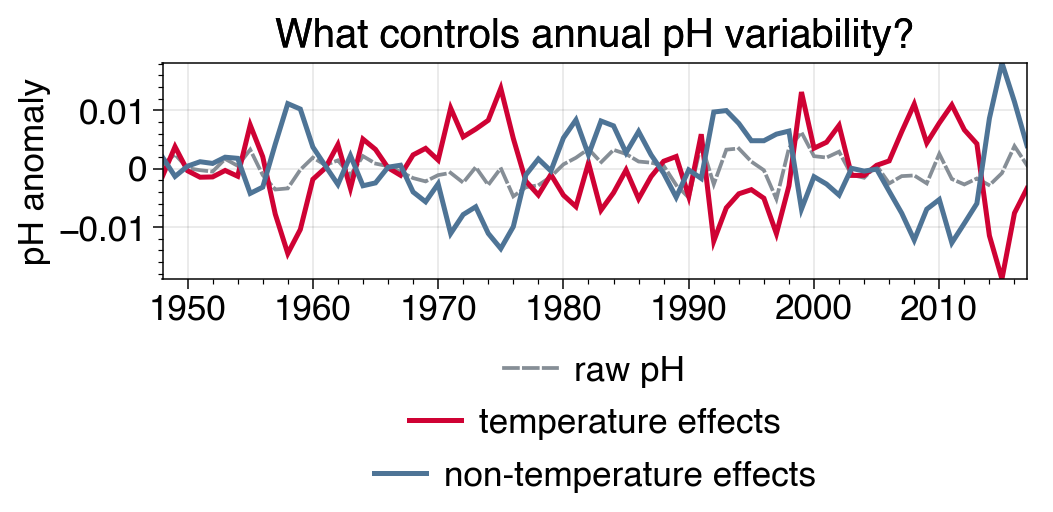

In [7]:
plot.nbsetup()
plot.rc['figure.facecolor'] = 'w'
plot.rc.small = 14
plot.rc.large = 16

f, ax = plot.subplots(axwidth=5, aspect=4, bottomlegend=True)

p0 = ax.plot(pH_aw.initialization, pH_aw, color='gray6', linewidth=1.5,
             label='raw pH', linestyle='--')
p1 = ax.plot(pH_T.initialization, pH_T, color='cherry', linewidth=2,
        label='temperature effects')
p2 = ax.plot(pH_nonT.initialization, pH_nonT, color='cadet blue', linewidth=2,
        label='non-temperature effects')

ax.format(title='What controls annual pH variability?',
          ylabel='pH anomaly')

f.bottompanel.legend([p0,p1,p2])

#for ext in ['.eps', '.png']:
#    et.vis.savefig('T.vs.nonT.pH.effects.annual', extension=ext, dpi=100)

### Correlate to Nino34 and NPGO Indices

---

Variability looks like it's driven by these events.

In [8]:
nino34 = xr.open_dataarray('/glade/work/rbrady/projects/CalCS_decadal_prediction/CVDP/nino34.FOSI.1948-2017.nc') \
           .rename({'year': 'initialization'})

In [9]:
npgo = xr.open_dataarray('/glade/work/rbrady/projects/CalCS_decadal_prediction/CVDP/NPGO.FOSI.194801-201712.nc') 
npgo = npgo.groupby('time.year').mean('time')
npgo = npgo.rename({'year': 'initialization'})

In [10]:
SST_aw.name = 'SST'
pH_aw.name = 'PH'
pH_T.name = 'pH_T'
pH_nonT.name = 'pH_nonT'

In [11]:
for lag, variable in zip(np.append([0]*4, [1]*4), [SST_aw, pH_aw, pH_T, pH_nonT]*2):
    r, p = cp.stats.xr_corr(nino34, variable, lag=lag, dim='initialization',
                     return_p=True)
    print(f'lag{str(lag)} corr(nino3.4, {variable.name}): {np.round(r.values,2)}, p: {np.round(p.values, 10)}')
    

lag0 corr(nino3.4, SST): 0.63, p: 4.333e-07
lag0 corr(nino3.4, PH): -0.07, p: 0.583148466
lag0 corr(nino3.4, pH_T): -0.63, p: 4.333e-07
lag0 corr(nino3.4, pH_nonT): 0.61, p: 4.8166e-06
lag1 corr(nino3.4, SST): 0.42, p: 0.0019429569
lag1 corr(nino3.4, PH): 0.4, p: 0.0014617045
lag1 corr(nino3.4, pH_T): -0.42, p: 0.0019429569
lag1 corr(nino3.4, pH_nonT): 0.57, p: 2.62881e-05


SMOOTHING

In [12]:
for smooth, variable in zip(np.array([0]*3 + [2]*3 + [3]*3 + [4]*3), [pH_aw, pH_T, pH_nonT]*6):
    if smooth != 0:
        npgo_smooth = et.stats.xr_smooth_series(npgo, dim='initialization', length=smooth).dropna('initialization')
        var_smooth = et.stats.xr_smooth_series(variable, dim='initialization', length=smooth).dropna('initialization')
        r, p = cp.stats.xr_corr(npgo_smooth, var_smooth, dim='initialization',
                         return_p=True)
    else:
        r, p = cp.stats.xr_corr(nino34, variable, dim='initialization',
                     return_p=True)
    if p < 0.05:
        print(f'smooth{str(smooth)} corr(NPGO, {variable.name}): {np.round(r.values,2)}, p: {np.round(p.values, 10)}***')
    else:
        print(f'smooth{str(smooth)} corr(NPGO, {variable.name}): {np.round(r.values,2)}, p: {np.round(p.values, 10)}')

smooth0 corr(NPGO, PH): -0.07, p: 0.583148466
smooth0 corr(NPGO, pH_T): -0.63, p: 4.333e-07***
smooth0 corr(NPGO, pH_nonT): 0.61, p: 4.8166e-06***
smooth2 corr(NPGO, PH): -0.09, p: 0.6742776557
smooth2 corr(NPGO, pH_T): 0.89, p: 5.473e-07***
smooth2 corr(NPGO, pH_nonT): -0.87, p: 1.83804e-05***
smooth3 corr(NPGO, PH): -0.19, p: 0.5178135476
smooth3 corr(NPGO, pH_T): 0.89, p: 0.0001469496***
smooth3 corr(NPGO, pH_nonT): -0.88, p: 0.001366491***
smooth4 corr(NPGO, PH): -0.26, p: 0.4638157953
smooth4 corr(NPGO, pH_T): 0.89, p: 0.001754508***
smooth4 corr(NPGO, pH_nonT): -0.88, p: 0.0060162015***


In [13]:
for smooth, variable in zip(np.array([0]*3 + [2]*3 + [3]*3 + [4]*3), [pH_aw, pH_T, pH_nonT]*6):
    if smooth != 0:
        nino_smooth = et.stats.xr_smooth_series(nino34, dim='initialization', length=smooth).dropna('initialization')
        var_smooth = et.stats.xr_smooth_series(variable, dim='initialization', length=smooth).dropna('initialization')
        r, p = cp.stats.xr_corr(nino_smooth, var_smooth, dim='initialization',
                         return_p=True)
    else:
        r, p = cp.stats.xr_corr(nino34, variable, dim='initialization',
                     return_p=True)
    if p < 0.05:
        print(f'smooth{str(smooth)} corr(Nino34, {variable.name}): {np.round(r.values,2)}, p: {np.round(p.values, 10)}***')
    else:
        print(f'smooth{str(smooth)} corr(Nino34, {variable.name}): {np.round(r.values,2)}, p: {np.round(p.values, 10)}')

smooth0 corr(Nino34, PH): -0.07, p: 0.583148466
smooth0 corr(Nino34, pH_T): -0.63, p: 4.333e-07***
smooth0 corr(Nino34, pH_nonT): 0.61, p: 4.8166e-06***
smooth2 corr(Nino34, PH): 0.02, p: 0.9030402449
smooth2 corr(Nino34, pH_T): -0.75, p: 2.7894e-06***
smooth2 corr(Nino34, pH_nonT): 0.71, p: 2.69476e-05***
smooth3 corr(Nino34, PH): 0.11, p: 0.6526856406
smooth3 corr(Nino34, pH_T): -0.82, p: 8.78899e-05***
smooth3 corr(Nino34, pH_nonT): 0.78, p: 0.0007567124***
smooth4 corr(Nino34, PH): 0.19, p: 0.5083393539
smooth4 corr(Nino34, pH_T): -0.83, p: 0.0007019416***
smooth4 corr(Nino34, pH_nonT): 0.8, p: 0.0025174789***


# Break non-temperature effects down

---

Computed dpH/dSALT, dpH/dDIC, dpH/dALK.

---

In [14]:
dpH_dSST = -0.0153
dpH_dALK = 0.00251
dpH_dDIC = -0.0017
dpH_dSALT = -0.01342

In [17]:
pH_SST = SST_aw * dpH_dSST
pH_sDIC = sDIC_aw * dpH_dDIC
pH_sALK = sALK_aw * dpH_dALK
pH_SALT = SALT_aw * dpH_dSALT
pH_resid = pH_aw - (pH_SST + pH_sDIC + pH_sALK + pH_SALT)

In [18]:
varlist = ['SST', 'sDIC', 'sALK', 'SALT', 'resid']
# standard deviation for estimate of its importance.
bars = []
for var in varlist:
    std = eval('pH_' + var).std()
    bars.append(std.values)

In [19]:
def plot_line(ax, var, color='cherry', label=None, **kwargs):
    p, = ax.plot(var.initialization, var, color=color, label=label,
                 linewidth=2, **kwargs)
    return p

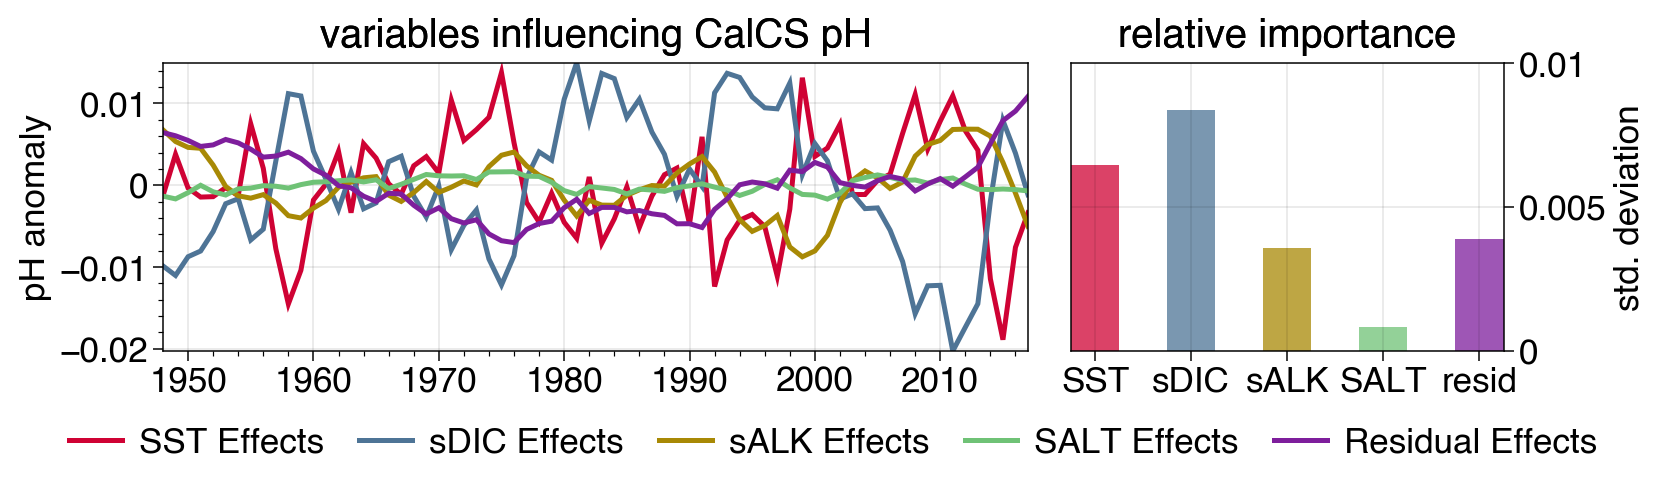

In [20]:
colorlist = ['cherry', 'cadet blue', 'dark mustard', 'soft green', 'purple']

plot.nbsetup()
plot.rc['figure.facecolor'] = 'w'
plot.rc.small = 14
plot.rc.large = 16

f, ax = plot.subplots(ncols=2, axwidth=4, aspect=3, 
                      sharey=False, wspace=0.4, wratios=[2,1],
                      bottomlegend=True)
labels = []
for var, color in zip(varlist, colorlist):
    if var == 'resid':
        p = plot_line(ax[0], eval('pH_' + var), color=color, label='Residual Effects')
    else:
        p = plot_line(ax[0], eval('pH_' + var), color=color, label=f'{var} Effects')
    labels.append(p)

# line aesthetics
ax[0].format(ylabel='pH anomaly', title='variables influencing CalCS pH')

    
# bar aesthetics
ax[1].bar(varlist, bars, align='center', alpha=0.75, width=0.5, color=colorlist)
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position('right')
ax[1].format(ylim=[0,0.01], ylabel='std. deviation', title='relative importance',
             yticks=[0,0.005,0.01])
ax[1].minorticks_off()


f.bottompanel.legend([labels])

#for ext in ['.eps', '.png', '.pdf']:
#    f.savefig('full.decomposition.annual.area.weighted' + ext)

## Maps of bar chart above

---

Need to think about best way to present maps for the influence of relative factors on pH. Will start out by making a map of the standard deviation of each effect.

In [21]:
pH = load_and_process('PH', order=2, area_weight=False)
#SST_aw = load_and_process('SST')
#SALT_aw = load_and_process('SALT')
#ALK_aw = load_and_process('ALK')
#DIC_aw = load_and_process('DIC')

In [22]:
help(project.viz.plot_CalCS_map)

Help on function plot_CalCS_map in module caldecpred.viz:

plot_CalCS_map(ax, data, cbar_on=True, cont_color='gray3', category_labeling=False, pcolor=True, TLONG_offset=-0.75, **kwargs)
    Generate pcolor plot of the California Current.
    
    This expects to receive a geoaxis object.
    
    Args:
        ax (geoaxis): axis object to plot over.
        data (xarray object): data to plot with TLAT and TLONG
        **kwargs: keyword arguments for the pcolor plot.
        cbar_on (optional bool): whether to plot a colorbar
        cont_color (optional str): color of continent
        category_labeling (optional bool): if True, label colorbar
                                           categorically
        pcolor (optional bool): If True, use pcolor. If False, use
                                    contourf.
        TLONG_offstep (optional float): Offset to move lon grid (so coastline
                                        doesn't overlap it too much)
        **kwargs: Goes to pcol

## Monthly perspective

Reload everything but at monthly resolution

In [23]:
pH = xr.open_dataset('/glade/scratch/rbrady/CalCS_decadal_prediction/masked_LME/PH.FOSI.CalCS.194801-201712.nc')
SST = xr.open_dataset('/glade/scratch/rbrady/CalCS_decadal_prediction/masked_LME/SST.FOSI.CalCS.194801-201712.nc')

In [24]:
# area-weight
pH_aw = et.stats.xr_area_weight(pH, area_coord='TAREA')['PH']
SST_aw = et.stats.xr_area_weight(SST, area_coord='TAREA')['SST']
# detrend
pH_aw = cp.stats.xr_rm_poly(pH_aw, order=2, dim='initialization')
SST_aw = cp.stats.xr_rm_poly(SST_aw, order=1, dim='initialization')

Summing over nlat
Summing over nlon
Summing over nlat
Summing over nlon


In [25]:
pH_aw = pH_aw.rename({'initialization': 'time'})
SST_aw = SST_aw.rename({'initialization': 'time'})

Decomposition

In [26]:
# Simple decomposition.
pH_T = SST_aw * fac
pH_nonT = pH_aw - pH_T

### Seasonal Means

In [27]:
def seasonal_averages(ds):
    def split_into_years(seas_avgs, start_idx):
        N = seas_avgs.time.size
        yr_seasons = seas_avgs.isel(time=slice(start_idx, N, 4))
        yr_seasons['time'] = yr_seasons['time.year']
        return yr_seasons
    
    seas_avgs = ds.resample(time="QS-JAN").mean('time')
    nyears = int(ds.time.size / 12)
    seas_avgs.coords['season'] = ('time', ['JFM','AMJ','JAS','OND']*nyears)
    # now split into individual season time series.
    JFM = split_into_years(seas_avgs, 0)
    AMJ = split_into_years(seas_avgs, 1)
    JAS = split_into_years(seas_avgs, 2)
    OND = split_into_years(seas_avgs, 3)
    return seas_avgs, JFM, AMJ, JAS, OND

In [28]:
_, JFM_T, AMJ_T, JAS_T, OND_T = seasonal_averages(pH_T)
_, JFM_nonT, AMJ_nonT, JAS_nonT, OND_nonT = seasonal_averages(pH_nonT)
_, JFM_pH, AMJ_pH, JAS_pH, OND_pH = seasonal_averages(pH_aw)

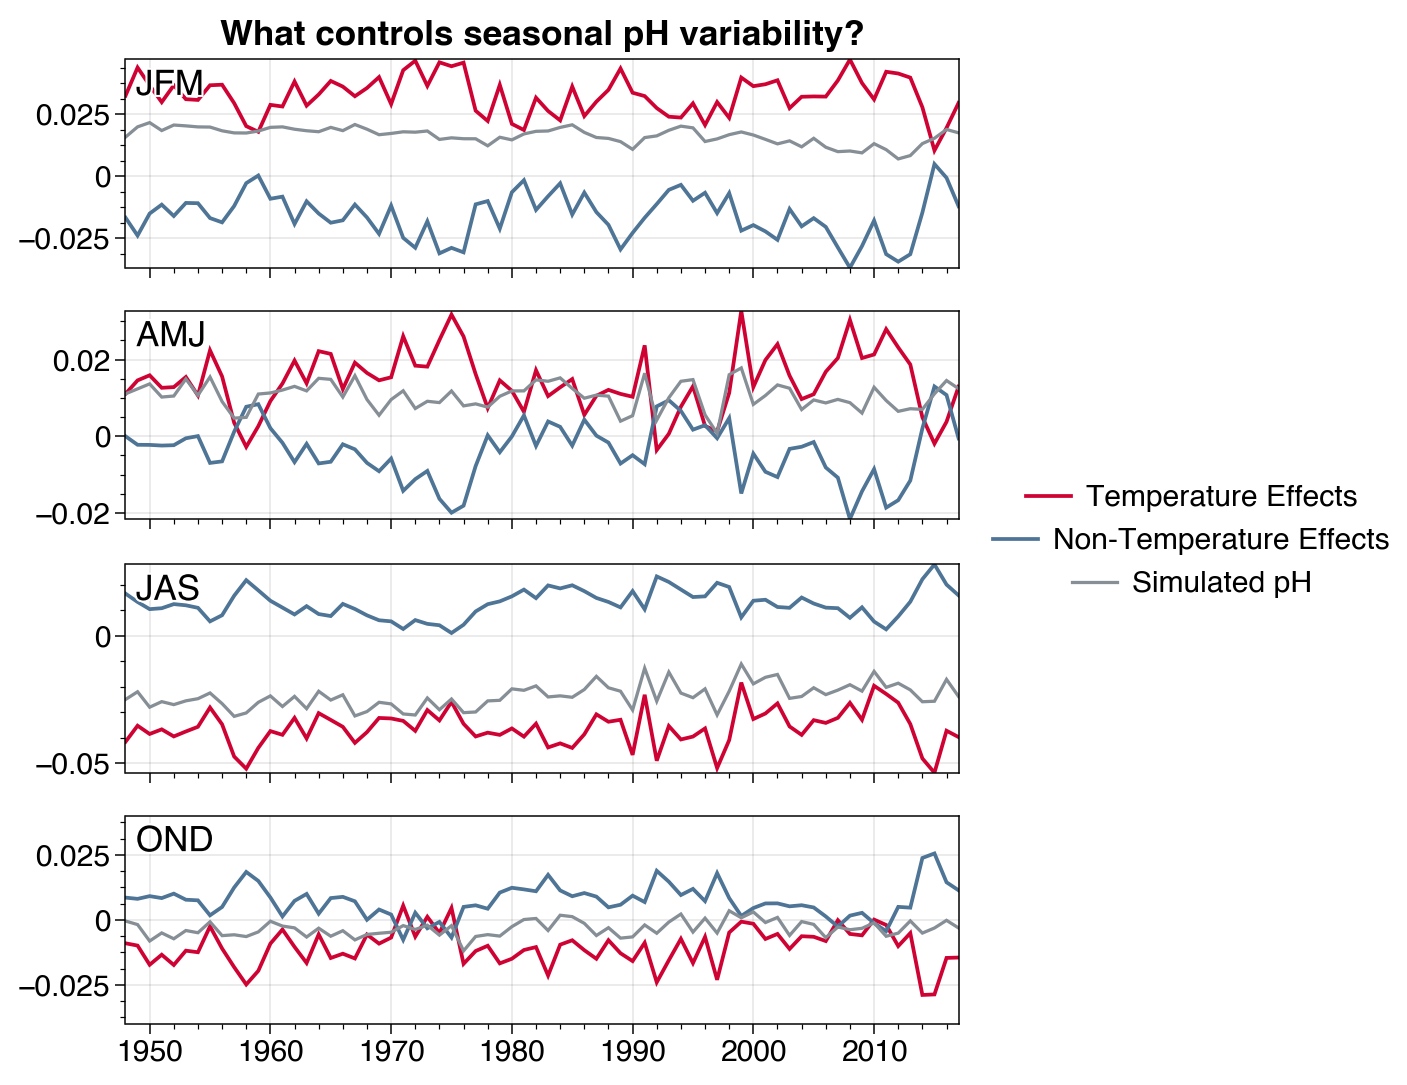

In [31]:
plot.rc.small = 12
plot.rc.large = 14
plot.rc['figure.facecolor'] = 'w'

def plot_cycles(ax, T, nonT, pH):
    p0 = ax.plot(T.time, T, color='cherry',
            linewidth=1.5, label='Temperature Effects')
    p1 = ax.plot(nonT.time, nonT, color='cadet blue',
            linewidth=1.5, label='Non-Temperature Effects')
    p2 = ax.plot(pH.time, pH, color='gray6',
                 label='Simulated pH')
    return p0, p1, p2

f, axs = plot.subplots(nrows=4, axwidth=5, aspect=4,
                       rightlegend=True, right=1.25)

for ax, season in zip(axs, ['JFM', 'AMJ', 'JAS', 'OND']):
    p0, p1, p2 = plot_cycles(ax, eval(season + '_T'), eval(season + '_nonT'),
                eval(season + '_pH'))
    ax.format(title=season, titlepos='li')
    
ax.format(ylim=[-0.04, 0.04])
f.rightpanel.legend([p0, p1, p2])
ttl = f.suptitle('What controls seasonal pH variability?')

#for ext in ['.eps', '.png']:
#    et.vis.savefig('T.vs.nonT.pH.effects.seasonal.by.year', extension=ext, dpi=100)

### Seasonal Cycle

In [32]:
spH_T = pH_T.groupby('time.month').mean('time')
spH_nonT = pH_nonT.groupby('time.month').mean('time')
pH_aw_seas = pH_aw.groupby('time.month').mean('time')

#### Standard Plot

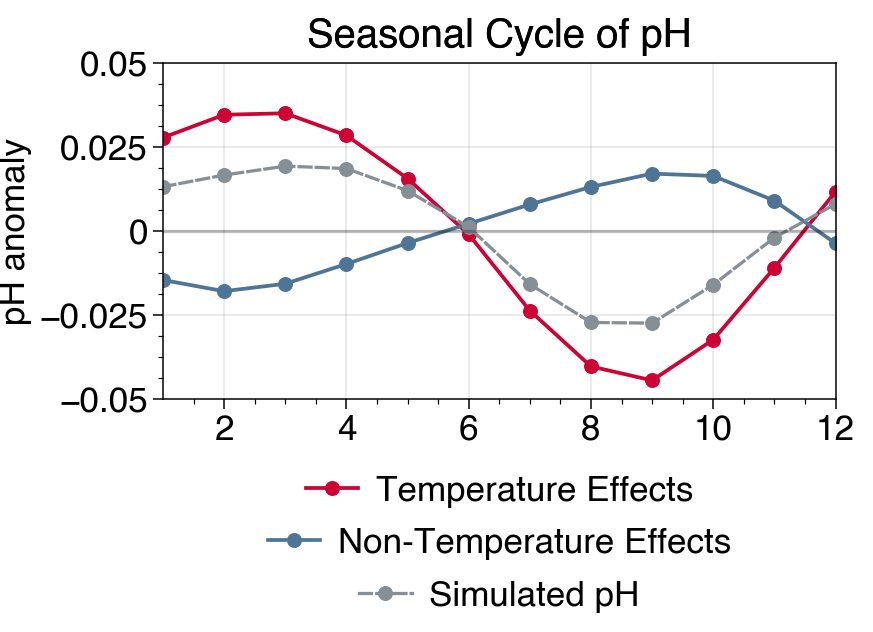

In [34]:
plot.rc.small = 14
plot.rc.large = 16
plot.rc['figure.facecolor'] = 'w'

f, ax = plot.subplots(axwidth=4, aspect=2, bottomlegend=True)

p0 = ax.plot(spH_T.month, spH_T, 'o-', markersize=6, color='cherry',
        label='Temperature Effects', linewidth=1.5)
p1 = ax.plot(spH_nonT.month, spH_nonT, 'o-', markersize=6, color='cadet blue',
        label='Non-Temperature Effects', linewidth=1.5)
p2 = ax.plot(pH_aw_seas.month, pH_aw_seas, 'o--', markersize=6, color='gray6',
        label='Simulated pH')

ax.axhline(y=0, color='k', alpha=0.25)

ax.format(ylim=[-0.05, 0.05],
          title='Seasonal Cycle of pH',
          ylabel='pH anomaly')
f.bottompanel.legend([p0,p1,p2])

#for ext in ['.eps', '.png']:
#    et.vis.savefig('T.vs.nonT.pH.effects.seasonal', extension=ext, dpi=100)

#### Radial Plot

In [35]:
# radial axis in radians.
months = np.arange(0, 360.01, 30)
months = np.deg2rad(months)

# data
spH_T_r = np.append(spH_T.values, spH_T.values[0])
spH_nonT_r = np.append(spH_nonT.values, spH_nonT.values[0])
pH_aw_seas_r = np.append(pH_aw_seas.values, pH_aw_seas.values[0])

In [38]:
plot.rc['legend.fontsize'] = 14
plot.rc['figure.facecolor'] = 'w'

f, ax = plot.subplots(axwidth=4, projection='polar',
                      bottomlegend=True)

# main line
p0 = ax.plot(months, spH_T_r, color='cherry', linestyle='-', linewidth=1, 
             label='Temperature Effects', alpha=0.5)
p1 = ax.plot(months, spH_nonT_r, color='cadet blue', linestyle='-', linewidth=1,
             label='Non-Temperature Effects', alpha=0.5)
p2 = ax.plot(months, pH_aw_seas_r, color='gray8', linestyle='-', linewidth=1,
             label='Simulated pH', alpha=0.5)

# positive values
ax.scatter(months[spH_T_r>0], spH_T_r[spH_T_r>0], s=50, color='cherry')
ax.scatter(months[spH_nonT_r>0], spH_nonT_r[spH_nonT_r>0], s=50, color='cadet blue')
ax.scatter(months[pH_aw_seas_r>0], pH_aw_seas_r[pH_aw_seas_r>0], s=50, color='gray8')


# negative values
ax.scatter(months[spH_T_r<0], spH_T_r[spH_T_r<0], s=50, edgecolor='cherry',
           facecolor='None')
ax.scatter(months[spH_nonT_r<0], spH_nonT_r[spH_nonT_r<0], s=50, edgecolor='cadet blue',
           facecolor='None')
ax.scatter(months[pH_aw_seas_r<0], pH_aw_seas_r[pH_aw_seas_r<0], s=50, edgecolor='gray8',
           facecolor='None')

## plot zero line as thick black line.
r = np.zeros(100,)
theta = np.linspace(np.deg2rad(0), np.deg2rad(360), num=100)
ax.plot(theta, r, linestyle='-', color='k',
        linewidth=1)

## aesthetics
ax.set_rlim([-0.05, 0.05])
#ax.set_rlabel_position(-115)
ax.set_xticks(months[:-1])
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                   fontsize=14)
ax.set_theta_direction(-1)
ax.set_theta_zero_location('N')

# titles, legend
f.bottompanel.legend([p0, p1, p2])
ttl = ax.set_title('Seasonal Cycle of pH', va='bottom', fontsize=18)
ttl.set_position([.5, 1.1])

#for ext in ['.eps', '.png']:
#    et.vis.savefig('T.vs.nonT.pH.effects.seasonal.radial', extension=ext, dpi=100)

AttributeError: 'super' object has no attribute 'smart_update'

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x2aaad90ffd08> (for post_execute):


IndexError: list index out of range

<Figure size 436.5x492.3 with 0 Axes>